#Supervised learning: stratigraphic units from well logs

This project uses labelled gamma ray logs and to predict stratigraphic units. Data comes from the Trenton - Black River project (http://www.wvgs.wvnet.edu/www/tbr/), which has been munged together with interpreted stratigraphy for easy use with scikit-learn.

In [86]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
import sklearn
%matplotlib inline

## Data parsing
This section reads in the data and generates a sample log plot. Notice that the majority of the log does not have an interpretation (NA), and the region we are interested in starts at a deeper depth.

In [23]:
def format_data(mat_data):
    """
    reformats matlab output into X, y, depth data where X is the log values, 
    y are the labels, and depth is the depth location.
    
    X: List of logs
    y: List of labels
    depth: List of depth profiles
    """
    dic = loadmat(mat_data)
    
    mat_struct = dic['data'].flatten()
    X = []
    depth = []
    y = []
    
    for curve in mat_struct:
        
        X.append(curve[1].flatten())
        depth.append(curve[2].flatten())
        
        y_unstruct = curve[0].flatten()
        y.append(np.array([i[0] for i in y_unstruct]))
    
    return X, y, depth
    

(6500, 4500)

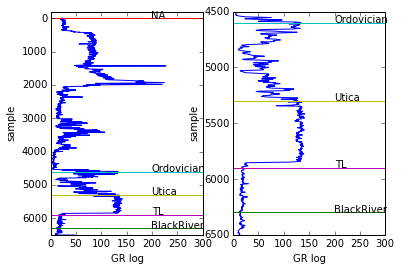

In [84]:
#### logs, labels, depth = format_data('labelled_logs.mat')

def plot_log(ignore=None):
    # plot a sample log
    plt.plot(logs[0], np.arange(logs[0].size));

    units, index = np.unique(labels[0], return_index=True)
    for i in index:
        
        plt.plot([0,300], [i,i])
        plt.xlabel('GR log')
        plt.ylabel('sample')

        if ignore and labels[0][i]=='NA':
            continue
        plt.text(200, i, labels[0][i])

plt.subplot(121)
plot_log()
plt.ylim(np.amax(index) + 200, np.amin(index) - 200)

plt.subplot(122)
plot_log(ignore=True)
plt.ylim(6500, 4500)


## Feature Extraction
It doesn't make sense to classify a well log sample by sample, so we need to extract windowed "features" from the log. Examples could be windowed statistics like mean, variance, kurtosis, as well as windowed transforms like the STFT or Wavelet transform. 

In [119]:
def feature_extraction(logs, labels, window_size, olap=.9):

    X = []
    y = []
    
    for log, labels in zip(logs, labels):
        
        step = np.ceil((window_size / (1-olap + .000001)))
        n_windows = int(log.size / step)
        
        wind_start = np.arange(n_windows)*step
        wind_end = wind_start + window_size
        
        #Xlog = []
        #ylog = []
        for i, window in enumerate(zip(wind_start, wind_end)):
            
            unit_labels, counts = np.unique(labels[window[0]:window[1]], return_counts=True)
        
            # If there are multiple, take the mode
            label = unit_labels[np.argmax(counts)]
            if label != 'NA':
                y.append(label)
                X.append([np.mean(log[window[0]:window[1]]), np.std(log[window[0]:window[1]])])
           
        
        
    return X, y

In [120]:
X, y = feature_extraction(logs, labels, 20)
print np.unique(y)

[u'BlackRiver' u'GullRiver' u'Kope' u'Ordovician' u'PointPleasant' u'TL'
 u'Utica' u'WellsCreek']


##Feature selection
Depending on what you choose as features, you might do a feature selection step which selects which features have the best variance or are the principle features

## Training and testing data sets
To use our labelled data to train a classifier, we need to split the data in training set we use for training, and a testing set we use to verify the classifier.

In [138]:
mapping = {lab:i for i, lab in enumerate(np.unique(y))}
Xtest = np.nan_to_num(np.array(X[0:len(X)/2]))
ytest =[mapping[i] for i in y[0:len(y)/2]]

Xtrain = np.nan_to_num(np.array(X[len(X)/2:]))
ytrain = [mapping[i] for i in y[len(y)/2:]]


##Classification

It is now time to choose a classfier. For mutliclass labelled data, K-Nearest Neighbours is the easiest and simplest methods. Other popular classifiers are state-vector machines (SVM) and decision trees.

In [143]:
from sklearn.neighbors.classification import KNeighborsClassifier as KNN

classifier = KNN(n_neighbors=5)

# load it up with the testing dataset
classifier.fit(Xtrain, ytrain)

# classify and score
print classifier.score(Xtest, ytest)

0.517711171662


[[[1.8888000000000003, 0.19965610433943667],
  [1.8981999999999999, 0.20019680317127947],
  [1.9062000000000001, 0.19930770180803353],
  [1.9128000000000003, 0.19749470878988129],
  [1.9184000000000001, 0.19476508927423317],
  [1.9243999999999999, 0.18972780502604256],
  [1.9251999999999998, 0.18932765249693456],
  [1.9252, 0.18932765249693456],
  [1.9240000000000004, 0.18986310858089311],
  [1.9216, 0.19103256266929994],
  [1.9179999999999999, 0.19271740969616633],
  [1.9145999999999999, 0.1948456825285077],
  [1.9117999999999997, 0.19703492076279275],
  [1.9093999999999998, 0.19922258908065626],
  [1.9077999999999999, 0.20089091567315834],
  [1.9066000000000001, 0.20230284229342901],
  [1.9059999999999999, 0.20310588371585894],
  [1.9057999999999999, 0.20340196655883153],
  [1.9047999999999998, 0.20487303385267672],
  [1.9031999999999996, 0.20715636606196783],
  [1.901, 0.21028789789238944],
  [1.8979999999999999, 0.21444812892632106],
  [1.8949999999999998, 0.21821319850091561],
  [